# Paladin analysis

Based on the [simultaneous analysis](simultaneous_analysis.ipynb) we see the frame levels as measured by Paladin are different to each other. Let's measure these values from the images so we can be sure of the method.

## Plan

* Get the list of images for one of the nights in question (20150609)
    * cameras 802 and 806
    * field NG2000
* For each image, measure:
    * raw frame mean
    * raw frame median
    * raw frame variance
    * left overscan
    * right overscan
    * bias subtracted frame mean
    * bias subtracted frame median
    * bias subtracted frame variance

In [236]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import glob
import sqlalchemy as sa
from contextlib import contextmanager
import bz2
from astropy.io import fits
from multiprocessing import Pool
import pandas as pd
import seaborn as sns
from scipy import stats

sns.set(style='white', context='poster')
colours = sns.color_palette(n_colors=6)

engine = sa.create_engine('mysql+pymysql://sw@ngtsdb/ngts_ops')
write_engine = sa.create_engine('sqlite:///results.db')

In [238]:
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker

Base = declarative_base(bind=write_engine)
Session = sessionmaker(bind=write_engine)

@contextmanager
def session_scope():
    """Provide a transactional scope around a series of operations."""
    session = Session()
    try:
        yield session
        session.commit()
    except:
        session.rollback()
        raise
    finally:
        session.close()

class ResultsRow(Base):
    __tablename__ = 'results'
    
    id = sa.Column(sa.Integer, primary_key=True)
    image_id = sa.Column(sa.BigInteger, nullable=False)
    mjd = sa.Column(sa.Float, nullable=False)
    camera_id = sa.Column(sa.Integer, nullable=False)
    raw_frame_mean = sa.Column(sa.Float, nullable=False)
    raw_frame_median = sa.Column(sa.Float, nullable=False)
    raw_frame_variance = sa.Column(sa.Float, nullable=False)
    left_overscan = sa.Column(sa.Float, nullable=False)
    right_overscan = sa.Column(sa.Float, nullable=False)
    bias_subtracted_frame_mean = sa.Column(sa.Float, nullable=False)
    bias_subtracted_frame_median = sa.Column(sa.Float, nullable=False)
    bias_subtracted_frame_variance = sa.Column(sa.Float, nullable=False)
    
    def __repr__(self):
        return '<Result {}>'.format(self.image_id)

In [242]:
def get_action(camera_id, field):
    r = engine.execute('''
    select distinct action_id from raw_image_list
    where camera_id = %s
    and field = %s
    and night = "20150609"
    ''', (camera_id, field))
    return r.first()[0]

In [244]:
action_802 = get_action(802, "NG2000-4500")
action_806 = get_action(806, "NG2000-4501")
print('Action 802:', action_802, ', action 806:', action_806)

Action 802: 104358 , action 806: 104376


In [246]:
@contextmanager
def open_file(fname):
    if '.bz2' in fname:
        with bz2.BZ2File(fname) as uncompressed:
            with fits.open(uncompressed) as infile:
                yield infile
    else:
        with fits.open(fname) as infile:
            yield infile

* For each image, measure:
    * raw frame mean
    * raw frame median
    * raw frame variance
    * left overscan
    * right overscan
    * bias subtracted frame mean
    * bias subtracted frame median
    * bias subtracted frame variance

In [248]:
def extract_data_from_frame(fname):
    with open_file(fname) as infile:
        all_data = infile[0].data
        header = infile[0].header
        
    row = dict(
        image_id=int(header['image_id']),
        mjd=float(header['mjd']),
        camera_id=int(header['cameraid']),
        raw_frame_mean=all_data.mean(),
        raw_frame_median=np.median(all_data),
        raw_frame_variance=all_data.var(),
        left_overscan=all_data[4:, :20].mean(),
        right_overscan=all_data[4:, -15:].mean())
    
    bias_subtracted = all_data - row['right_overscan']
    
    row['bias_subtracted_frame_mean'] = bias_subtracted.mean()
    row['bias_subtracted_frame_median'] = np.median(bias_subtracted)
    row['bias_subtracted_frame_variance'] = bias_subtracted.var()
    return row

In [250]:
files_802 = glob.glob('/ngts/testdata/paranal/action{}_observeField/IMAGE*.fits.bz2'.format(action_802))
files_806 = glob.glob('/ngts/testdata/paranal/action{}_observeField/IMAGE*.fits.bz2'.format(action_806))

In [252]:
def upload_data(files, pool, sessioncls=Session):
    data = pool.map(extract_data_from_frame, files)
    session = sessioncls()
    session.add_all([ResultsRow(**row) for row in data])
    session.commit()
    session.close()

Finally we have the cached data into a sqlite file, load it up into memory with pandas

In [257]:
df = pd.read_sql_table('results', write_engine)
lmr_key = 'left-minus-right'
df[lmr_key] = df['left_overscan'] - df['right_overscan']

In [258]:
df.head()

,id,image_id,mjd,camera_id,raw_frame_mean,raw_frame_median,raw_frame_variance,left_overscan,right_overscan,bias_subtracted_frame_mean,bias_subtracted_frame_median,bias_subtracted_frame_variance,left-minus-right
0,1,80220150610030154,57183.126319,802,1488.512451,1472,411002.21875,1278.365112,1276.306519,212.206406,195.693481,411002.21875,2.058594
1,2,80220150610025422,57183.121088,802,1494.978394,1479,399754.37500,1278.825684,1276.921875,218.055847,202.078125,399754.37500,1.903809
2,3,80220150610030206,57183.126458,802,1488.630737,1472,410037.03125,1278.377686,1276.232056,212.399353,195.767944,410037.03125,2.145630
3,4,80220150610025440,57183.121296,802,1495.366211,1479,399407.03125,1278.672852,1276.688721,218.677078,202.311279,399407.15625,1.984131
4,5,80220150610030219,57183.126609,802,1488.641113,1472,409957.78125,1278.262695,1276.225464,212.416336,195.774536,409957.78125,2.037231


In [259]:
df_802, df_806 = df[df['camera_id'] == 802].sort('mjd'), df[df['camera_id'] == 806].sort('mjd')

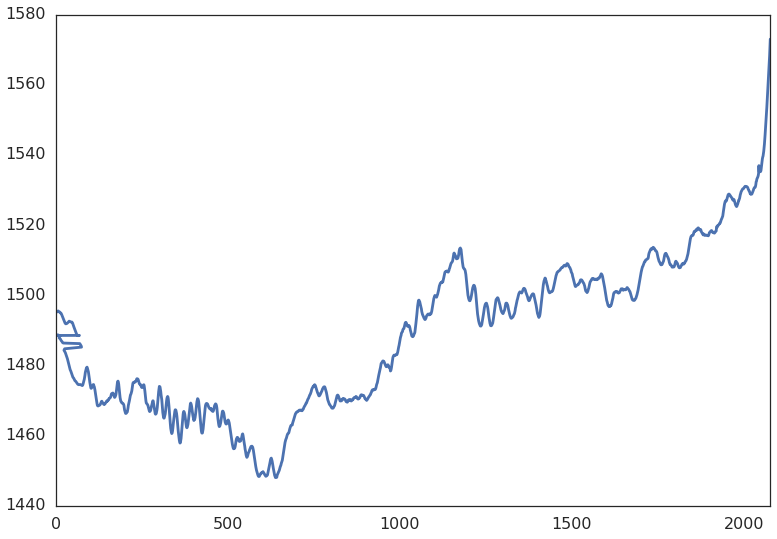

In [260]:
df_802.raw_frame_mean.plot()

### Analysis

First we look at the bias subtracted levels to see if they match up to what we saw previously.

In [261]:
@contextmanager
def subplots(*args, **kwargs):
    grid = kwargs.pop('grid', True)
    fig, axes = plt.subplots(*args, **kwargs)
    yield (fig, axes)
    if grid:
        try:
            for ax in axes:
                ax.grid(True)
        except TypeError:
            axes.grid(True)
    fig.tight_layout()

In [262]:
def bin_data(mjd, data, bins, statistic='median'):
    dmjd = mjd % 1
    if not isinstance(bins, np.ndarray):
        bins = np.linspace(dmjd.min(), dmjd.max(), bins)
    binned, _, _ = stats.binned_statistic(dmjd, data, statistic=statistic, bins=bins)
    return (bins, binned)

In [263]:
bin_begin, bin_end = 0.1, 0.45
bin_minutes = 1.
nbins = (bin_end - bin_begin) * 86400. / 60. / bin_minutes
bins = np.linspace(bin_begin, bin_end, nbins)

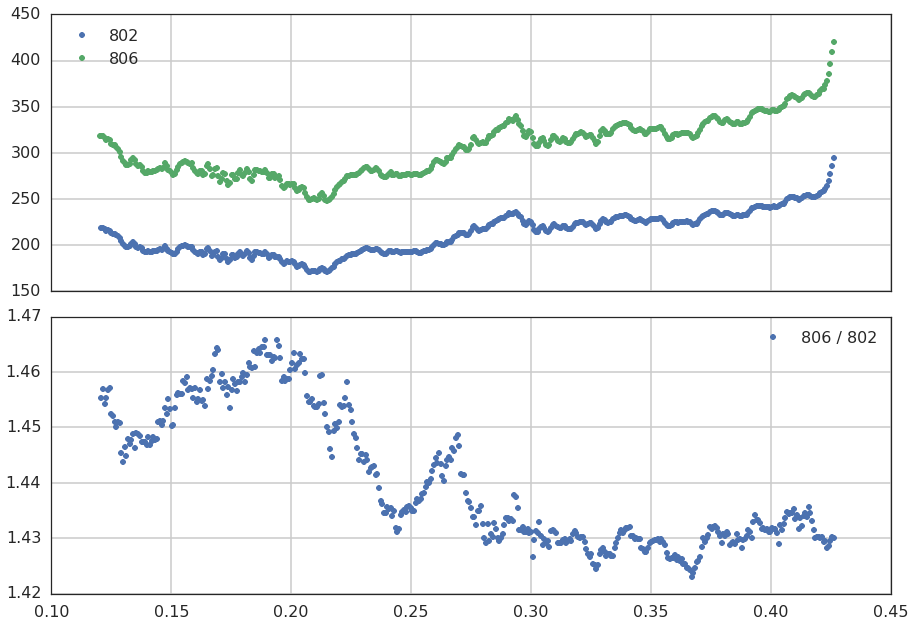

In [264]:
frame_ratio = (bin_data(df_806.mjd, df_806.bias_subtracted_frame_mean, bins)[1] /
         bin_data(df_802.mjd, df_802.bias_subtracted_frame_mean, bins)[1])

with subplots(2, 1, sharex=True) as (fig, axes):
    for name, g in df.groupby('camera_id'):
        _, by = bin_data(g.mjd, g.bias_subtracted_frame_mean, bins)
        axes[0].plot(bins[:-1], by, '.', label=name)
    axes[0].legend(loc='best')
    
    axes[1].plot(bins[:-1], frame_ratio, '.', label='806 / 802')
    axes[1].legend(loc='best')

We have the ratio between median levels, perhaps this is related to a difference in left-right values?

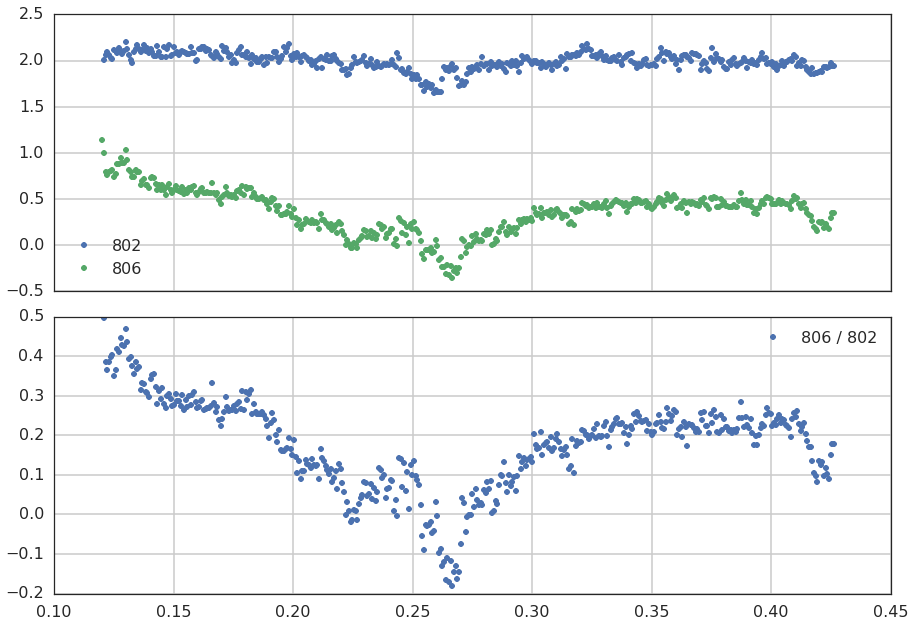

In [265]:
bias_difference_ratio = (bin_data(df_806.mjd, df_806[lmr_key], bins)[1] /
         bin_data(df_802.mjd, df_802[lmr_key], bins)[1])

with subplots(2, 1, sharex=True) as (fig, axes):
    for name, g in df.groupby('camera_id'):
        _, by = bin_data(g.mjd, g[lmr_key], bins)
        axes[0].plot(bins[:-1], by, '.', label=name)
    axes[0].legend(loc='best')
    axes[1].plot(bins[:-1], bias_difference_ratio, '.', label='806 / 802')
    axes[1].legend(loc='best')

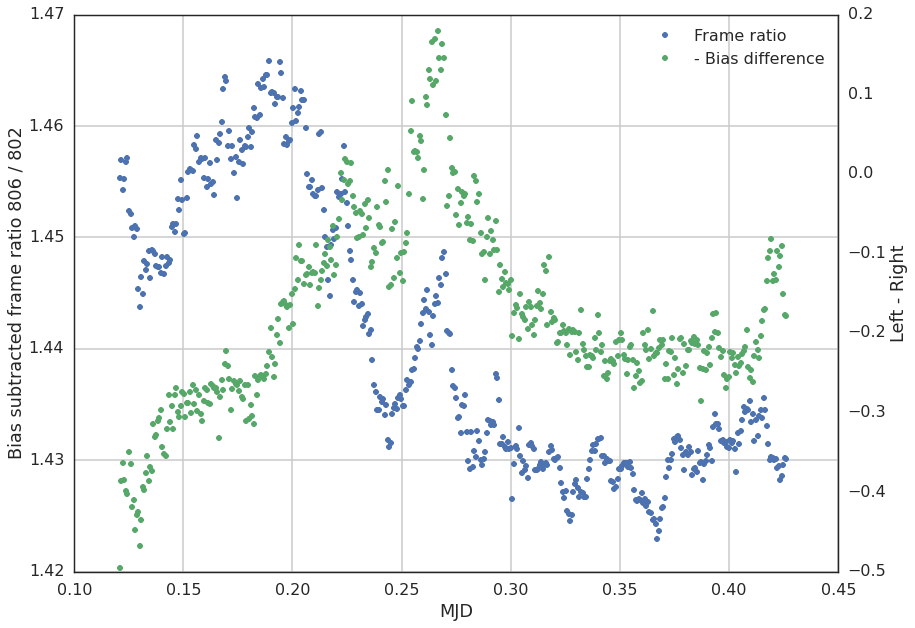

In [266]:
with subplots() as (fig, axis):
    lines = []
    lines.append(axis.plot(bins[:-1], frame_ratio, '.',
             color=colours[0])[0])
    tax = axis.twinx()
    lines.append(tax.plot(bins[:-1], bias_difference_ratio * -1., '.', color=colours[1])[0])
    axis.legend(lines, ['Frame ratio', '- Bias difference'], loc='best')
    axis.set(xlabel='MJD', ylabel='Bias subtracted frame ratio 806 / 802')
    tax.set(ylabel='Left - Right')

There is a feature at around $\Delta \mathrm{mjd} \approx 0.26$ which corresponds, and the tailing off afterwards appear similar, but the early region does not look that similar.